<a href="https://colab.research.google.com/github/akiFQC/adversarial_training_pytorch/blob/master/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from matplotlib import pyplot as plt

In [0]:
class Net(nn.Module):
    def __init__(self, spectral_norm=False):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3,  padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.fc = nn.Linear(128, 10)

        if spectral_norm:
            nn.utils.spectral_norm(self.conv1)
            nn.utils.spectral_norm(self.conv2)
            nn.utils.spectral_norm(self.conv3)
            nn.utils.spectral_norm(self.conv4)
            nn.utils.spectral_norm(self.conv5)
            nn.utils.spectral_norm(self.conv6)
            nn.utils.spectral_norm(self.fc)
        self.dropout1  = nn.Dropout(0.3)
        self.dropout2  = nn.Dropout(0.3)    
        self.dropout3  = nn.Dropout(0.3)    


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = self.dropout3(x.view(x.size(0), -1))
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)
        return output
    
    def extract(self, x):
        feats = {}
        x = self.conv1(x)
        feats["conv1"] = x.cpu().detach().numpy()
        x = F.relu(x)
        x = self.conv2(x)
        feats["conv2"] = x.cpu().detach().numpy()
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = self.conv3(x)
        feats["conv3"] = x.cpu().detach().numpy()
        x = F.relu(x)
        x = self.conv4(x)
        feats["conv4"] = x.cpu().detach().numpy()
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        x = self.conv5(x)
        feats["conv5"] = x.cpu().detach().numpy()
        x = F.relu(x)
        x = self.conv6(x)
        feats["conv6"] = x.cpu().detach().numpy()
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = self.dropout3(x.view(x.size(0), -1))        
        x = self.fc(x)
        feats["fc"] = x.cpu().detach().numpy()
        output = F.log_softmax(x, dim=1)
        feats["prob"] = output.cpu().detach().numpy()
        return feats


In [0]:
def fgsm(model, x, y, epsilon=1):
    x.requires_grad_()
    pred = model(x)
    loss = F.nll_loss(pred, y, reduction='sum')
    grad=torch.autograd.grad(loss, x)[0].detach()
    grad /= torch.norm(grad, p=2, dim=(1, 2, 3), keepdim=True)
    return x+grad*epsilon

def plot_data(data):
    plt.imshow(data.numpy()[0, 0, :, :], cmap="gray")
    plt.show()

In [0]:
def train(model, device, train_loader, optimizer, epoch, logs, adv_train = False):
    model.train()
    loss_run = 0
    correct = 0
    correct_adv =0 

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = F.nll_loss(output, target, reduction='sum')
        loss_run += loss.item()
        # adv 
        if adv_train :
            x_adv = fgsm(model, data, target)
            output_adv = model(x_adv)
            correct_adv += pred.eq(target.view_as(pred)).sum().item()
            loss += F.nll_loss(output_adv, target, reduction='sum')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logs["acc_train"].append(100. * correct / len(train_loader.dataset))
    print("Train set: Average loss running: {:.4f},".format(loss_run/ len(train_loader.dataset)), end="")
    logs["loss_train"].append(loss_run/ len(train_loader.dataset))
    if adv_train:
        logs["acc_train_adv"].append(100. * correct_adv / len(train_loader.dataset))


def test( model, device, test_loader, logs, adv_test=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    logs["loss_test"].append(test_loss)
    logs["acc_test"].append(100. * correct / len(test_loader.dataset))


    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    if adv_test:
        model.eval()
        test_loss_adv = 0
        correct_adv = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = fgsm(model, data, target)
            with torch.no_grad():
                output = model(data)
                test_loss_adv += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct_adv += pred.eq(target.view_as(pred)).sum().item()

        test_loss_adv /= len(test_loader.dataset)
        logs["loss_test_adv"].append(test_loss_adv)
        logs["acc_test_adv"].append(100. * correct_adv / len(test_loader.dataset))

        
        


def pertu_layers(model, device, loader, logs):
    if not "diff_layers" in logs:
        logs["diff_layers"] ={}
        logs["diff_layers_std"] ={}

    model.to(device)
    diffs = {}
    sum_feats = {}
    model.eval()
    for data, target in loader :
        with torch.no_grad():
            feat = model.extract(data.to(device))
        x_adv = fgsm(model, data.to(device), target.to(device), epsilon=1)
        with torch.no_grad():
            feat_adv = model.extract(x_adv.to(device))
        for k in feat:
            diff = feat[k] - feat_adv[k]
            basize = diff.shape[0]
            if k in diffs:
                diffs[k] +=np.linalg.norm(diff.reshape([basize, -1]), axis=1).tolist()
            else:
                diffs[k] = np.linalg.norm(diff.reshape([basize, -1]), axis=1).tolist()
            if k in sum_feats:
                sum_feats[k] += np.linalg.norm(feat[k].reshape([basize, -1]), axis=1).sum()
            else:
                sum_feats[k] = np.linalg.norm(feat[k].reshape([basize, -1]), axis=1).sum()
    
    for k in sum_feats:
        diffs[k] = np.asarray(diffs[k])
        diffs[k] /= sum_feats[k] * len(loader.dataset)
        logs["diff_layers"][k] = np.mean(diffs[k])
        logs["diff_layers_std"][k] = np.std(diffs[k])

        

In [0]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

print(device)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()
                    ])),
    batch_size= 256, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor()
                    ])),
    batch_size=256, shuffle=True, **kwargs)


EPOCH= 15

logs_total  = {} 

# vanilla
model = Net().to(device)
optimizer = optim.Adam(model.parameters())
logs_vanilla = {"loss_train":[], "loss_test":[], "acc_test":[], "acc_train":[], "acc_test_adv":[], "loss_test_adv":[], "acc_train_adv":[]}
for epoch in range(1, EPOCH + 1):
    train(model, device, train_loader, optimizer, epoch, logs_vanilla, adv_train=False)
    test(model, device, test_loader, logs_vanilla, adv_test=True)
pertu_layers(model, device, test_loader, logs_vanilla)
logs_total["vanilla"] = logs_vanilla

# adv train
model = Net().to(device)
optimizer = optim.Adam(model.parameters())
logs_adv = {"loss_train":[], "loss_test":[], "acc_test":[], "acc_train":[], "acc_test_adv":[], "loss_test_adv":[], "acc_train_adv":[]}
for epoch in range(1, EPOCH + 1):
    train(model, device, train_loader, optimizer, epoch, logs_adv, adv_train=True)
    test(model, device, test_loader, logs_adv, adv_test=True)
pertu_layers(model, device, test_loader, logs_adv)
logs_total["adv"] = logs_adv

#spectral norm
model = Net(spectral_norm=True).to(device)
optimizer = optim.Adam(model.parameters())
logs_sn = {"loss_train":[], "loss_test":[], "acc_test":[], "acc_train":[], "acc_test_adv":[], "loss_test_adv":[], "acc_train_adv":[]}
for epoch in range(1, EPOCH + 1):
    train(model, device, train_loader, optimizer, epoch, logs_sn, adv_train=False)
    test(model, device, test_loader, logs_sn, adv_test=True)
pertu_layers(model, device, test_loader, logs_sn)
logs_total["sn"] = logs_sn



cuda
Train set: Average loss running: 0.4617,Test set: Average loss: 0.0828, Accuracy: 9724/10000 (97%)

Train set: Average loss running: 0.0877,Test set: Average loss: 0.0443, Accuracy: 9850/10000 (98%)

Train set: Average loss running: 0.0632,Test set: Average loss: 0.0286, Accuracy: 9895/10000 (99%)

Train set: Average loss running: 0.0481,Test set: Average loss: 0.0237, Accuracy: 9906/10000 (99%)

Train set: Average loss running: 0.0422,Test set: Average loss: 0.0206, Accuracy: 9926/10000 (99%)

Train set: Average loss running: 0.0353,Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99%)

Train set: Average loss running: 0.0316,Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99%)

Train set: Average loss running: 0.0285,Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99%)

Train set: Average loss running: 0.0267,Test set: Average loss: 0.0174, Accuracy: 9936/10000 (99%)

Train set: Average loss running: 0.0259,Test set: Average loss: 0.0200, Accuracy: 9938/10000 (9

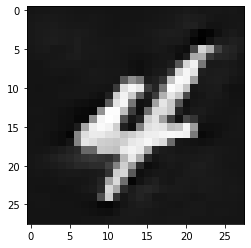

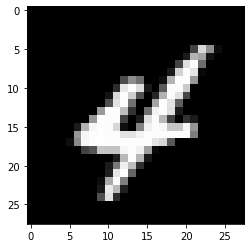

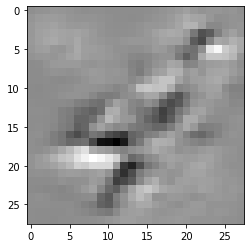

In [0]:
data, y = next(iter(test_loader))
adv_data = fgsm(model, data.to(device), y.to(device), epsilon=1)
plot_data(adv_data.detach().cpu() )
plot_data(data.detach().cpu() )
plot_data(adv_data.detach().cpu() - data.detach().cpu() )

In [0]:
def plot_curve(logs):
    fig, ax =   plt.subplots(3, 1, figsize=(4, 4*3))
    for k in logs:
        if isinstance(logs[k], list) :
            if len(logs[k]) > 1:
                if "loss" in k: 
                    l = len(logs[k])
                    ax[0].plot(np.arange(1, l+1), logs[k], label=str(k))
                elif "acc" in k:
                    l = len(logs[k])
                    ax[1].plot(np.arange(1, l+1), logs[k], label=str(k))
    ax[0].set_ylabel("loss")

    ax[1].set_ylabel("accuracy")
    ax[0].set_xlabel("iteration")
    ax[1].set_xlabel("iteration")
    ax[0].legend()
    ax[1].legend()
    #ax[0].grid()
    #ax[1].grid()
    layers = list(logs["diff_layers"].keys())
    ax[2].errorbar(layers, logs["diff_layers"].values(), 
                   yerr = logs["diff_layers_std"].values())
    ax[2].set_ylabel("normalized distance between x and x + r")    
    ax[2].set_xlabel("layers")    
    ax[2].set_yscale("log")    

    ax[2].legend()
    
    plt.show()


No handles with labels found to put in legend.


vanilla


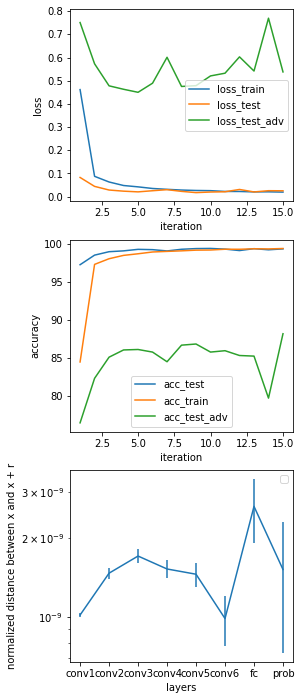

No handles with labels found to put in legend.


adv train


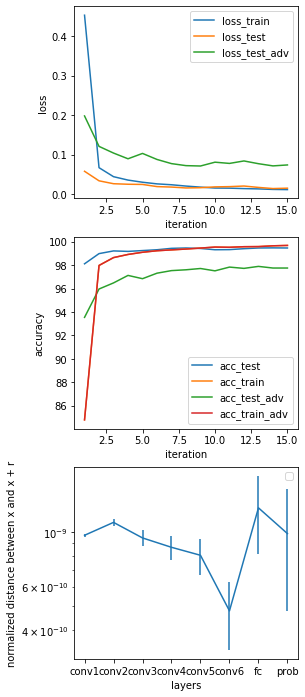

No handles with labels found to put in legend.


specral normalization train


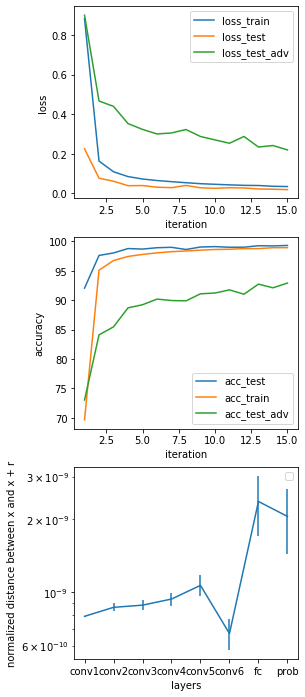

In [0]:
print("vanilla")
plot_curve(logs_vanilla)

print("adv train")
plot_curve(logs_adv)

print("specral normalization train")
plot_curve(logs_sn)

In [0]:
def plot_curve_3(lostoflogs):
    lcon = len(lostoflogs)
    fig, ax =   plt.subplots(lcon, 3, figsize=(5*3, 5*lcon), sharey="row")
    for i, s in enumerate(lostoflogs):
        logs = lostoflogs[s]
        for k in logs:
            if isinstance(logs[k], list) :
                if len(logs[k]) > 1:
                    if "loss" in k: 
                        l = len(logs[k])
                        ax[0,i].plot(np.arange(1, l+1), logs[k], label=str(k))
                    elif "acc" in k:
                        l = len(logs[k])
                        ax[1,i].plot(np.arange(1, l+1), logs[k], label=str(k))
        ax[0,i].set_ylabel("loss")
        ax[0,i].set_title(s)

        ax[1,i].set_ylabel("accuracy")
        ax[0,i].set_xlabel("iteration")
        ax[1,i].set_xlabel("iteration")
        ax[0,i].legend()
        ax[1,i].legend()
        layers = list(logs["diff_layers"].keys())
        ax[2,i].errorbar(layers, logs["diff_layers"].values(), 
                    yerr = logs["diff_layers_std"].values())
        ax[2,i].set_ylabel("normalized distance between x and x + r")    
        ax[2,i].set_xlabel("layers")    
        ax[2,i].set_yscale("log")    
        ax[2,i].legend()
    plt.tight_layout()
    plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


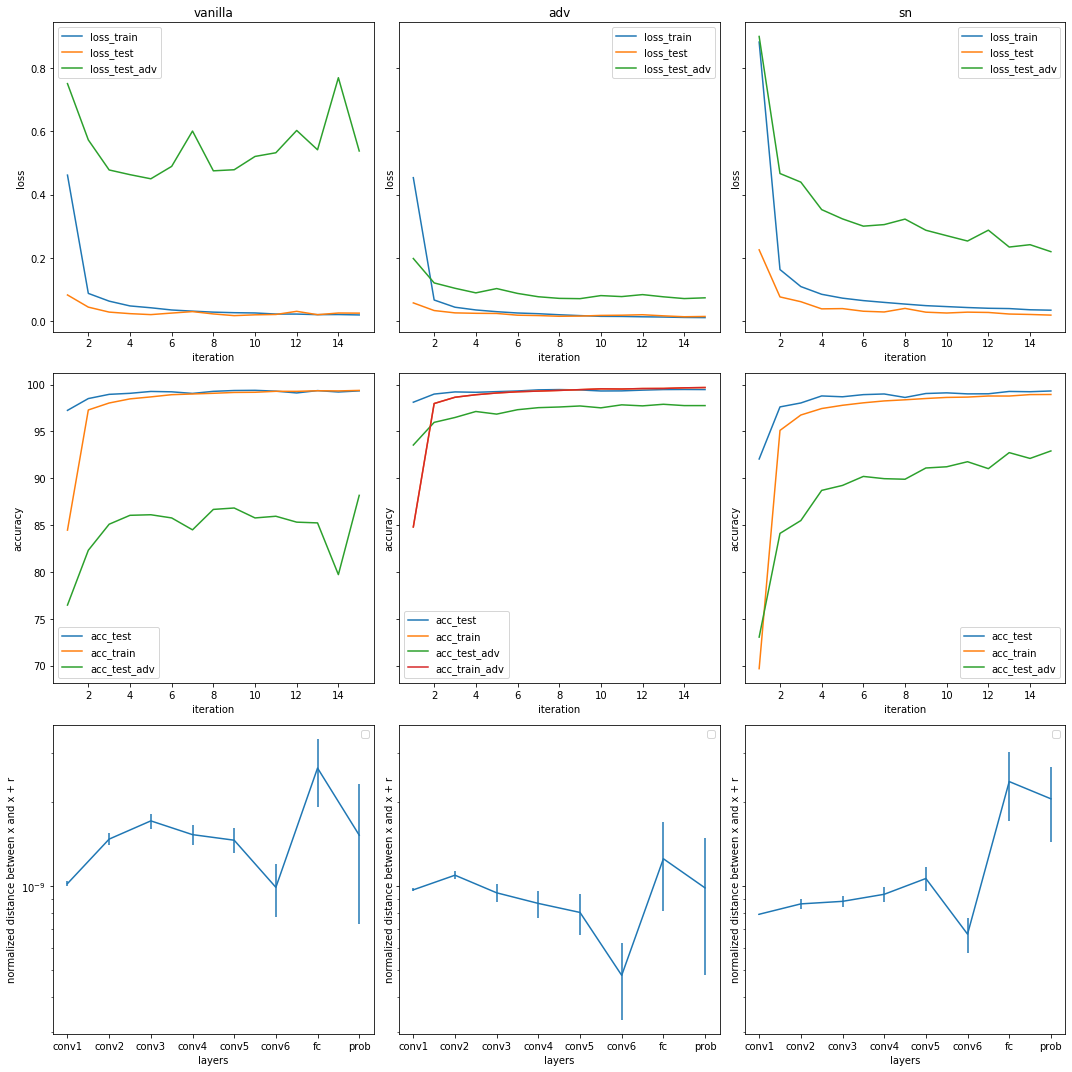

In [0]:
plot_curve_3(logs_total)